# SCS training conditions

In [47]:
# df[(df['handle_time'] > 500000) & (df['aht'] > 450)]
# start_date = 2018-01-20

# Step 1: Load Data

In [48]:
from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.metrics import mean_absolute_error
import re
from forecast import *

# create a pandas dataframe object
df1 = pd.read_csv('../data/scs_aht_vol.csv')
h = pd.read_csv('../data/holidays.csv')

names = get_col_names(df1)
df1.rename(columns=names, inplace=True)
df1['date'] = pd.to_datetime(df1['date'])
df1.index = df1['date']
display(df1.head())

df = df1.copy()

,date,handle_time,handle_time_forecast,volume,volume_forecast
date,,,,,
2016-01-01,2016-01-01,1317.0,NaN,6.0,0.0
2016-01-02,2016-01-02,0.0,NaN,0.0,0.0
2016-01-03,2016-01-03,0.0,NaN,0.0,0.0
2016-01-04,2016-01-04,2177265.0,NaN,3251.0,3051.0
2016-01-05,2016-01-05,1613619.0,NaN,2118.0,2466.0


# Step 2: Clean and Analyze Data

The handle time and volume boxplots below show major outliers near 0, and a long tail of values in the uppper ranges.

In [49]:
# create column for aht
df['aht'] = df['handle_time']/df['volume']

df['aht_forecast'] = df['handle_time_forecast']/df['volume_forecast']

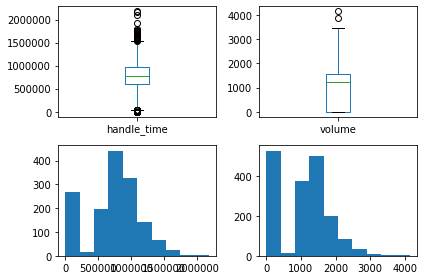

In [50]:
plot_time_vol(df)

# What is the date range for the training data?
The available training data spans from January 4th, 2016 through August 13th, 2020

In [51]:
print('Start:', df.index.min())
print('End:', df.index.max())

Start: 2016-01-01 00:00:00
End: 2020-10-18 00:00:00


# Does the dataset contain weekends?
No it was prefiltered

In [52]:
df.index.weekday.isin([5,6]).any(), df.index.isin(h.iloc[:,0].tolist()).any()

(True, True)

# Does the dataset contain holidays?
Yes, there are several holidays with data and a forecast; these will be omitted from the dataset for now.

In [53]:
df = df[~df.index.isin(h.iloc[:,0].tolist())]
df = df[~df.index.weekday.isin([5,6])]

In [54]:
# validate that no dates in the training data are weekends or holidays
df.index.weekday.isin([5,6]).any(),df.index.isin(h.iloc[:,0].tolist()).any()

(False, False)

## Is there any zero data or missed holidays?
Yes, a number of special holidays in 2016 were missed. These dates shall be omitted.

In [55]:
display(df[df['handle_time'] < 500000])

# filter dataframe
df = df[(df['handle_time'] > 500000) & (df['aht'] > 450)]

,date,handle_time,handle_time_forecast,volume,volume_forecast,aht,aht_forecast
date,,,,,,,
2016-01-01,2016-01-01,1317.0,NaN,6.0,0.0,219.500000,NaN
2016-01-18,2016-01-18,373897.0,NaN,538.0,719.0,694.975836,NaN
2016-02-15,2016-02-15,377611.0,NaN,541.0,552.0,697.987061,NaN
2016-03-25,2016-03-25,343339.0,NaN,504.0,607.0,681.228175,NaN
2016-05-30,2016-05-30,0.0,NaN,0.0,0.0,NaN,NaN
2016-07-04,2016-07-04,0.0,NaN,0.0,0.0,NaN,NaN
2016-09-05,2016-09-05,0.0,NaN,0.0,0.0,NaN,NaN
2016-11-24,2016-11-24,0.0,NaN,0.0,0.0,NaN,NaN
2016-11-25,2016-11-25,499988.0,NaN,929.0,775.0,538.200215,NaN


# Is there any null data?

All null data is due to handle time forecast not being recorded prior to 2020.

In [56]:
df.isna().any()

date                    False
handle_time             False
handle_time_forecast     True
volume                  False
volume_forecast         False
aht                     False
aht_forecast             True
dtype: bool

# What date is the outlier value for handle time?
There was an unusually low handle time on April 23rd. That data point should be ommitted.

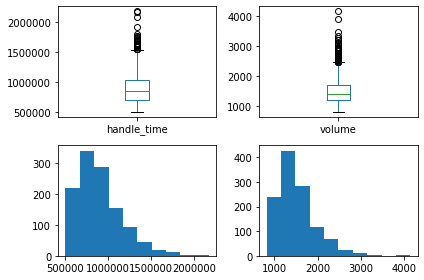

In [57]:
plot_time_vol(df)

# How has the aht changed over time?

- The aht takes an interesting dip in mid-late 2018, and has been steadily increasing through 2020.

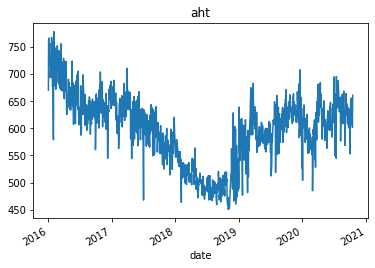

In [58]:
ax = df['aht'].plot()
plt.title('aht')
plt.show()

# How has handle time and Volume changed over time?

The handle time and volume appear to follow the same seasonality, with matching peaks and troughs.

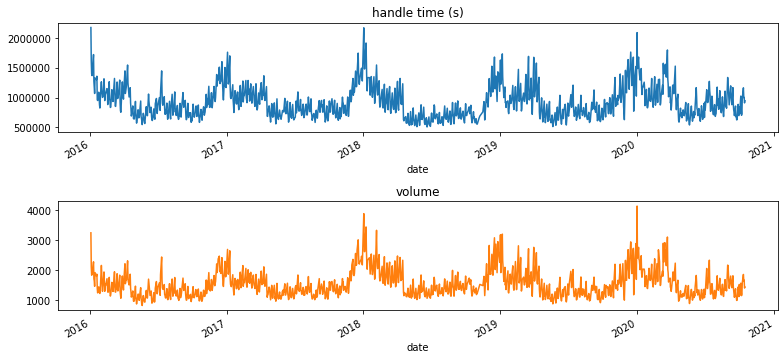

In [59]:
plt.figure(figsize=(11,7))
plt.subplot(311)
df['handle_time'].plot(color='#1f77b4')
plt.title('handle time (s)')
plt.subplot(312)
df['volume'].plot(color='#ff7f0e')
plt.title('volume')
plt.tight_layout()
plt.show()

# What is the relationship between volume and handle time?
There is a strong linear relationship between volume and handle time. As volume increases, total handle time increases, while higher volumes have more variable handle times. The scatter plot below confirms the intuition.

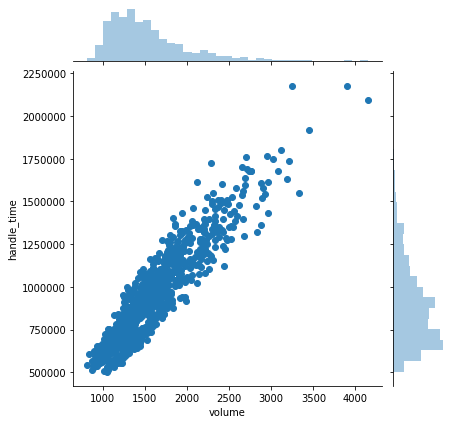

In [60]:
_ = sns.jointplot(x='volume', y='handle_time', data=df)

# What is the relationship between volume and aht?
There is a very weak linear relationship that is nearly flat.  As volume increases, aht decreases slightly.

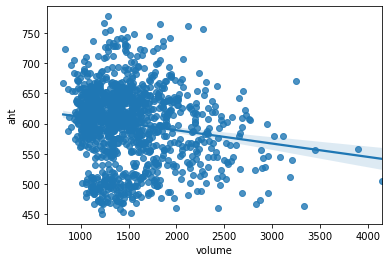

In [61]:
_ = sns.regplot(data=df,x='volume', y='aht' )

# What is the relationship between handle time and aht?
There is a strong linear relationship; As the total handle time increases, the aht tends to increase.

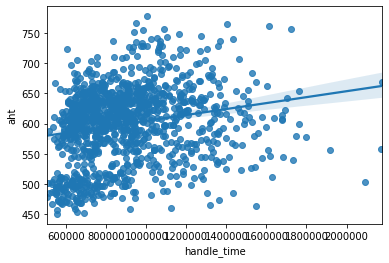

In [62]:
_ = sns.regplot(data=df,x='handle_time', y='aht' )

In [63]:
# validate aht forecast is only null where handle_time_forecast is null 
(df[df['handle_time_forecast'].notnull()].index == df[df['aht_forecast'].notnull()].index).all()

True

# What date do the forecasts begin?


In [64]:
df[df['aht_forecast'].notnull()].head(1)

,date,handle_time,handle_time_forecast,volume,volume_forecast,aht,aht_forecast
date,,,,,,,
2020-06-01,2020-06-01,765321.0,860520.0,1281.0,1388.0,597.440281,619.971182


# What are the summary statistics of volume, handle time and aht?
- The median volume is `447`

- The median handle time is `252,102 seconds` or `70 hours`

- The median aht is around `577 seconds` or `9.6 minutes` per call

In [65]:
df[['volume', 'handle_time', 'aht']].describe()

,volume,handle_time,aht
count,1177.000000,1.177000e+03,1177.000000
mean,1511.412065,9.022420e+05,599.760079
std,438.829299,2.587983e+05,61.592779
min,816.000000,5.049300e+05,450.565253
25%,1195.000000,7.012310e+05,562.993021
50%,1408.000000,8.514310e+05,608.976569
75%,1703.000000,1.037976e+06,638.764620
max,4148.000000,2.177265e+06,777.522886


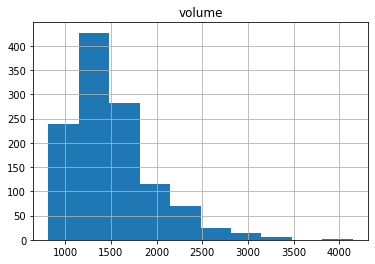

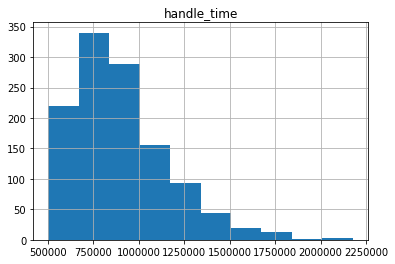

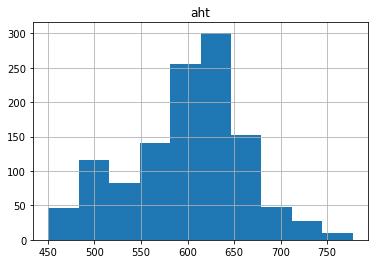

In [66]:
for col in ['volume', 'handle_time', 'aht']:
    df[col].hist()
    plt.title(col)
    plt.show()

# Step 3: Create Training Data and Fit Model for handle time
In order to train our model, we need to define a start and end date for the training data.
Typically, training should be performed with the most relevant or recent data.

In [67]:
# create a new dataframe with 2 columns, date and actual volume received
df['date'] = df.index
df = df[['date', 'handle_time']]

# Must pre-format column names
df.columns = ['ds','y']

# set start date of training data
df = df[df['ds'] >= '2016-03-10']

# set end date of training data
df = df[df['ds'] < '2020-06-01']
df.head()

,ds,y
date,,
2016-03-10,2016-03-10,850474.0
2016-03-11,2016-03-11,923286.0
2016-03-14,2016-03-14,1261189.0
2016-03-15,2016-03-15,985309.0
2016-03-16,2016-03-16,983784.0


# Begin Training Model
Since this is the first model, only the default settings will be used. These settings, or hyperparameters can be tuned later, and will be a part of the model's feature engineering. Refer to the Prophet documentation at the [top of the page](#docs)

In [68]:
# create default prophet model
m = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
m.fit(df)

# Create future dates
This function allows us to create the future dates that we want to predict. We will start with creating the next hundred days after August 13, 2020.

In [69]:
future = m.make_future_dataframe(periods=200)
future.tail()

,ds
1228,2020-12-11
1229,2020-12-12
1230,2020-12-13
1231,2020-12-14
1232,2020-12-15


In [70]:
# get rid of holidays and weekends
future = future[(~future['ds'].isin(h.iloc[:,0].tolist())) & (~future['ds'].dt.weekday.isin([5,6]))]

# Make Predicitons on future dates

In [71]:
forecast = m.predict(future)

# view only the last 5 predictions with confidence intervals 
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1167,2020-12-09,1.282756e+06,1.119889e+06,1.439173e+06
1168,2020-12-10,1.276191e+06,1.111032e+06,1.446994e+06
1169,2020-12-11,1.323138e+06,1.171690e+06,1.482951e+06
1170,2020-12-14,1.620766e+06,1.462023e+06,1.782818e+06
1171,2020-12-15,1.468471e+06,1.305826e+06,1.648883e+06


# Visualize handle time seasonality and analyze trends.
The dark blue line is the prediction, the light blue line is the confidence interval, and the black dots is the actual volume. 

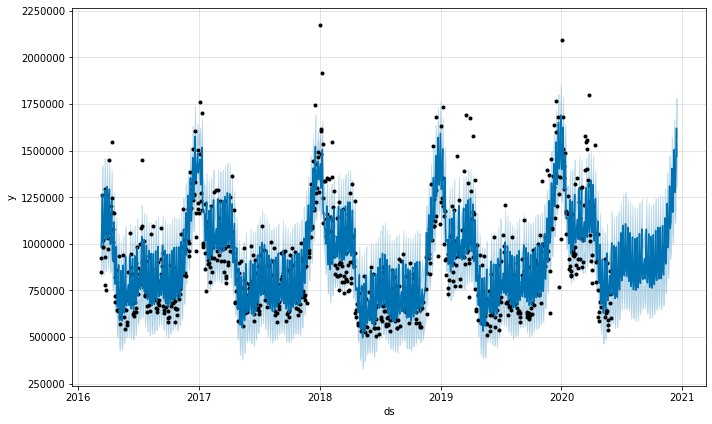

In [72]:
fig1 = m.plot(forecast)

# What is the trend and seasonality for handle time?

<b>Trend</b>: The handle time was decreasing in 2018 then began rising sharply into 2019 and 2020.

<b>Weekly</b>: Monday is the highest handle time decreasing to wednesday and thursday is the lowest with an slight increase again on Friday.

<b>Yearly</b>: The yearly seasonality shows the highest handle time at the beginning and even more so at the end of the calendar year, with a hump in March and a lull throughout the summer and into the fall.

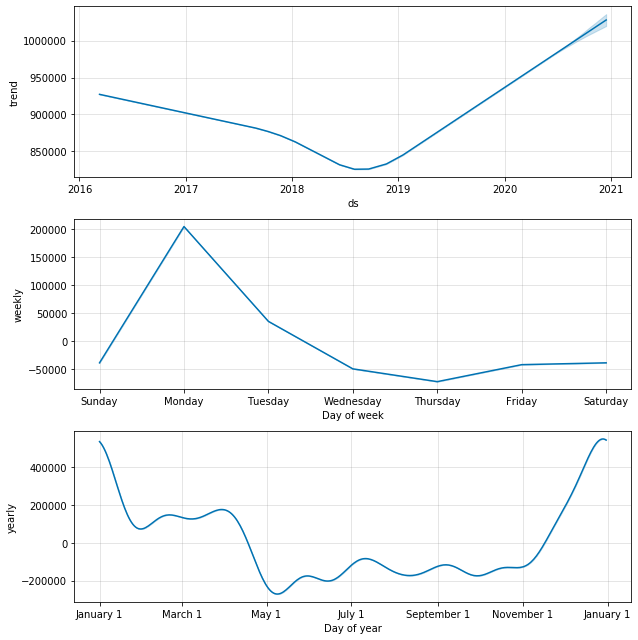

In [73]:
fig2 = m.plot_components(forecast)